# Missteering measurement at 5 GeV

Measurement at 5 GeV firing again KFA45 at the second injection instance. Three kicks possible: 60, 70, 80 kV

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.21.1.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.07.19
Your IP is 172.17.0.19
2018-08-14 14:20:09
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PI2_KFA45.AQN1.value',
                'PI2_KFA45.CCV.value', 
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionTrajectoryBBB.value.channelNames',
                'PR_BCT_ST.Samples.value.samples']



In [4]:
# let's start with the matlab data
files60 = sorted(glob.glob(folderPath+'/60kV/2018*.mat'))
print 'Found ' + str(len(files60)) + ' data files'
files70 = sorted(glob.glob(folderPath+'/70kV/2018*.mat'))
print 'Found ' + str(len(files70)) + ' data files'
files80 = sorted(glob.glob(folderPath+'/80kV/2018*.mat'))
print 'Found ' + str(len(files80)) + ' data files'
files0 = sorted(glob.glob(folderPath+'/zero_kick/2018*.mat'))
print 'Found ' + str(len(files80)) + ' data files'
files0_2 = sorted(glob.glob(folderPath+'/zero_kick_after/2018*.mat'))
print 'Found ' + str(len(files80)) + ' data files'

files = files0+files60+files70+files80+files0_2

Found 12 data files
Found 12 data files
Found 11 data files
Found 11 data files
Found 11 data files


In [125]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

In [80]:
# set the kicker voltage to zero when the kicker is off
myDataFrame['PI2_KFA45.CCV.value'].loc[myDataFrame['PI2_KFA45.AQN1.value'] == 0.] = 0.

# Data cleanup

In [81]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

Dropped 5 duplicate(s)
---
Removed 1 fault BPM acquisition(s)
---


# Import the optics model

In [24]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/PS_twiss_files/ps_6.21_6.185.twiss')

Problem parsing: @ ORBIT_-CT        %le                  -0

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [83]:
# emix_norm_PSB = 2.484
# emiy_norm_PSB = 2.076

# emix_geom_PSB = emix_norm_PSB/(betar*gammar)
# emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

# Match the tomogram data

In [84]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [85]:
# new tomogram analysis
files60 = sorted(glob.glob(folderPath+'/60kV_tomo/*.dat'))
# del(files60[10])
files70 = sorted(glob.glob(folderPath+'/70kV_tomo/*.dat'))
files80 = sorted(glob.glob(folderPath+'/80kV_tomo/*.dat'))
files0 = sorted(glob.glob(folderPath+'/zero_kick_tomo/*.dat'))
files0_2 = sorted(glob.glob(folderPath+'/zero_kick_after_tomo/*.dat'))
files_tomo = files0+files60+files70+files80+files0_2

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_003.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_005.dat


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: loadtxt: Empty input file: "/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_005/d001.data"



IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_006.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_007.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_008.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_009.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo/autosave_010.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_tomo


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_after_tomo/autosave_010.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_after_tomo/autosave_011.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_after_tomo/autosave_012.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_after_tomo/autosave_013.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.19/zero_kick_after_tomo/autosave_014.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBl

In [86]:
timeTolerance = 22

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

49/58 are within the timeTolerance
length of dataframe is: 55


In [87]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [88]:
myDataFrame.to_pickle('imported_data_2018.07.19.pkl')

In [5]:
# myDataFrame=pnd.read_pickle('imported_data_2018.07.19.pkl')

# Intensity

In [6]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1400]/x[1350] )

Text(0,0.5,u'Peak intensity (10^10 ppb)')

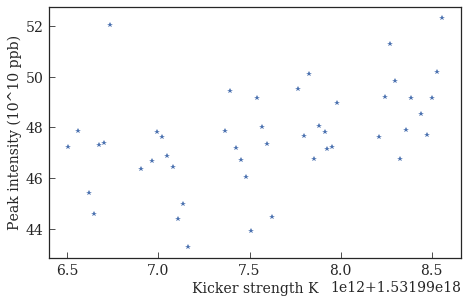

In [7]:
plt.plot(myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')


Text(0,0.5,u'Losses')

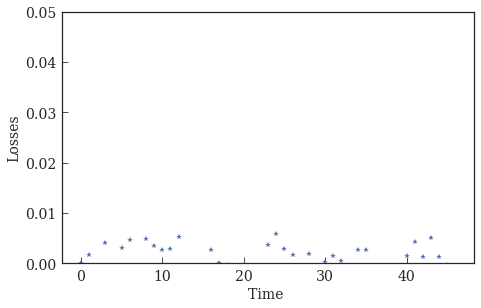

In [8]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

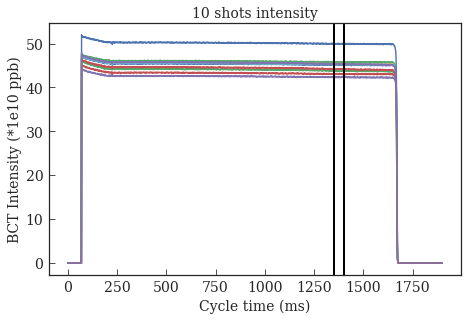

In [9]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=1350, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=1400, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [10]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [12]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [13]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [14]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

In [16]:
# find indexes of the shots at the same kick
ks = []
ks_idx = []
for k in range(len(myDataFrame)):
    if k == 0 :
        prevk = myDataFrame['PI2_KFA45.CCV.value'].iloc[k]
        ks.append(prevk)
        ks_idx.append(k)
        continue
#     print(k)
    
    thisk = myDataFrame['PI2_KFA45.CCV.value'].iloc[k]
    if (prevk-thisk) != 0:
#         print(thisk)
        ks.append(thisk)
        ks_idx.append(k)
    prevk = thisk

In [17]:
k_values = np.array((myDataFrame['PI2_KFA45.CCV.value'].iloc[ks_idx]))

emix_mean = np.empty(len(ks_idx),dtype=float)
emiy_mean = np.empty(len(ks_idx),dtype=float)
emix_std = np.empty(len(ks_idx),dtype=float)
emiy_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]])



## Emittance plot

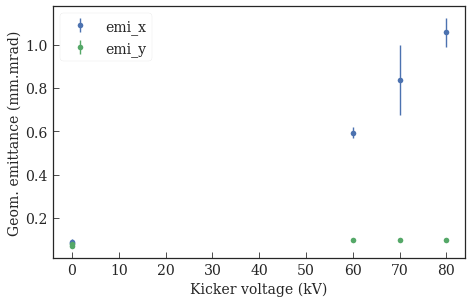

In [18]:
fig, ax = plt.subplots(1)

ax.errorbar(k_values, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax.errorbar(k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

plt.xlabel('Kicker voltage (kV)')
plt.ylabel('Geom. emittance (mm.mrad)')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))



plt.legend(frameon=True)

fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

## Get the voltage to kick calibration

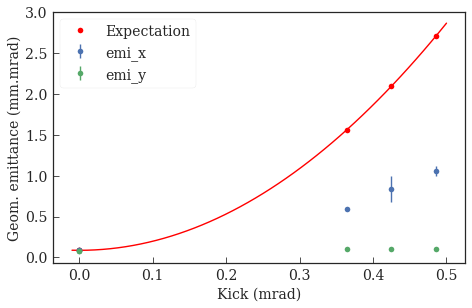

In [20]:
fig, ax = plt.subplots(1)

kicks = KFA45_volt_to_kick(k_values, 5)

ax.errorbar(1e3*kicks, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax.errorbar(1e3*kicks, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

plt.xlabel('Kick (mrad)')
plt.ylabel('Geom. emittance (mm.mrad)')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))


### ANALYTICAL EXPECTATION
def emi_th(kick, epsg_0):
    beta = 22.24
    return epsg_0 + 0.5*beta*(kick**2)

kick_plt = np.linspace(-0.01, 0.5)
plt.plot(1e3*kicks, 1e6*emi_th(kicks, 1e-6*emix_mean[0]), 'ro', label='Expectation')
plt.plot(kick_plt, 1e6*emi_th(1e-3*kick_plt, 1e-6*emix_mean[0]), 'r-')

plt.legend(frameon=True)

fig.savefig('emi_xy.eps', format='eps')

# BPMs

In [25]:
# BPMs
myDataFrame['BPMx'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,:])
myDataFrame['BPMy'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,:])

#legacy from now on
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [26]:
# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []
BPM_betay = []
BPM_alphay = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])
        BPM_betay.append(optics.BETA22[k])   
        BPM_alphay.append(optics.ALFA22[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]
BPM_betay = [BPM_betay[-1]] + BPM_betay[:-1]
BPM_alphay = [BPM_alphay[-1]] + BPM_alphay[:-1]

# casting stuff
BPM_betax = np.array(BPM_betax)
BPM_alphax = np.array(BPM_alphax)
BPM_betay = np.array(BPM_betay)
BPM_alphay = np.array(BPM_alphay)

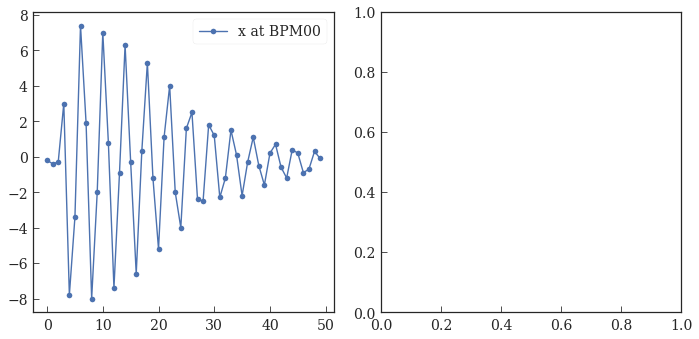

In [27]:
k=30
off = 0
m = 0
ydata1 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,:50]).values[k] #thisBPM
ydata2 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m+1,:50]).values[k] #nextBPM

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(ydata1,'o-',label='x at BPM00')

ax[0].legend(frameon=True, loc=1)
fig.tight_layout()

# Calculate injection oscillation from the BPM

[ 12.74462727   1.60886392   0.74490441  -4.29459537 -18.76843512]
12.1622366364


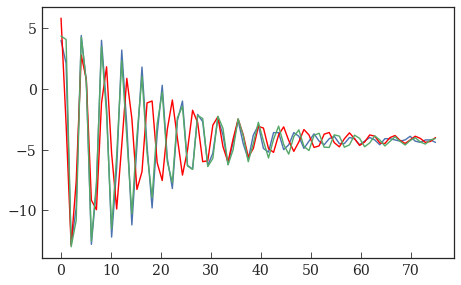

In [28]:
m=1
k = 30
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,5:80]).values[k]


from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d, t):
    return a * np.exp(x/t) * np.sin(b*x + c) + d

xdata = np.linspace(0,75,75)
plt.plot(xdata, ydata)

bounds=([0., .8*pi/5, -pi, -np.inf, -np.inf],[np.inf,pi,pi,np.inf, 0.])
p0 = ([10, 0.45*pi, pi/2, np.mean(ydata), -20])
plt.plot(xdata, f_to_fit(xdata, *p0),'r')

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)

yfit = f_to_fit(xdata, *p)
plt.plot(xdata, yfit)

print(p)

print((ydata.max() - ydata.min())/np.sqrt(2))

In [257]:
'''
hmmmmm .... maybe it is better to just use max and min ...
Sounds more resilient as algorythm
'''

'\nhmmmmm .... maybe it is better to just use max and min ...\nSounds more resilient as algorythm\n'

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [29]:
# loop over all the BPM --> in vertical ! 
verticalMode = False

if verticalMode:
    off = 43
else:
    off = 0

chi2_thr = 1.   
    
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# statistical check

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
        # starting values
        osc_amplitude[k,m] = (ydata.max()-ydata.min())/np.sqrt(2)
            
print 'Done.'

Done.


Beta_x at PR.BPM00: 12.038661


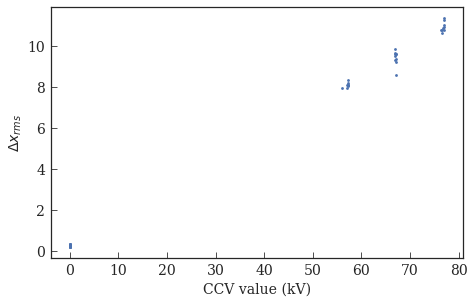

In [35]:
# manual inspection
shiftVal=0
bpm_n = 0
plt.plot(myDataFrame['PI2_KFA45.AQN1.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
plt.xlabel('CCV value (kV)')
plt.ylabel('$\Delta x_{rms}$')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [276]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

# myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

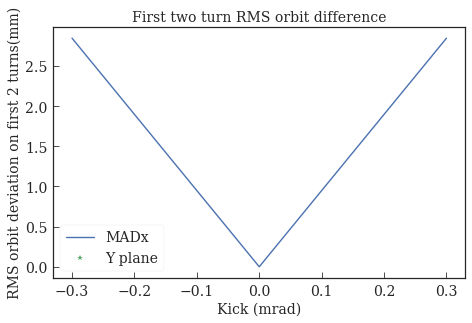

In [278]:
# DATA ONLY
# plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

# plt.xlabel('Kick (mrad)')
# plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
# plt.title('First two turn RMS orbit difference')

# # plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



# plt.legend(frameon=True)
# x1,x2,y1,y2 = plt.axis()
# # plt.axis((x1,x2,0,8))
# # plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Comparison data + MADx 
kick_params = np.load('/eos/user/e/esenes/PS-injection-steering/MADx/6.21-6.185_kick_to_angle_params.npy')
xkick = np.array([ -0.3, 0., 0.3])
# off=1.5
plt.plot(xkick, kick_params[1] + np.abs(kick_params[0]*xkick),label='MADx')

rk=0
plt.plot(1e3*(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal) - rk),myDataFrame['deltaX_2turns'].values,'*',label='Y plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

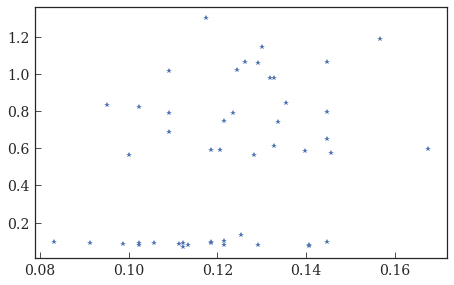

In [279]:
plt.plot(myDataFrame['deltaX_2turns'].values, myDataFrame['WS_geom_emittance_x'],'*',label='X plane')


In [133]:
xrms12_mean = np.empty(len(ks_idx),dtype=float)
xrms12_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 



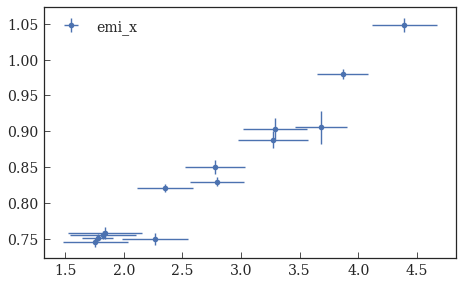

In [134]:
plt.errorbar(xrms12_mean, emix_mean, xerr=xrms12_std, yerr=emiy_std, fmt='o',label='emi_x')
plt.legend()

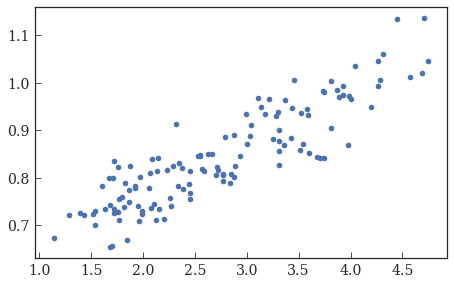

In [112]:
plt.plot(myDataFrame['deltaX_2turns'].values,myDataFrame['WS_geom_emittance_x'],'o')

# Methods comparison

## 1) Single BPM method

In [36]:
bpm_n1 = 0
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 1
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM00 betax=12.038661 alphax=0.009937008495
Expected value for the fit a=0.0415369593071
At PR.BPM03 betax=22.10670041 alphax=0.01858203422
Expected value for the fit a=0.0226253867254


Model function: a(x)^2 + c
Fit params: a=0.00795519714187 c= 9.39755765517e-08
 
At PR.BPM00 betax=12.038661 alphax=0.009937008495
Expected value for the fit a=0.0415369593071


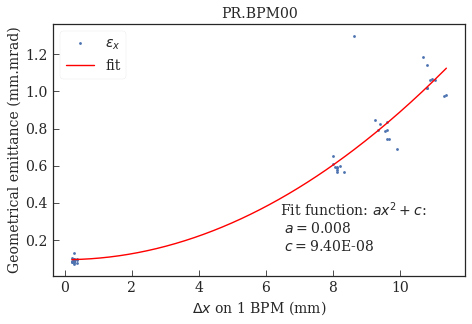

In [37]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

Model function: a(x)^2 + c
Fit params: a=0.00619165862001 c= 9.40783194294e-08
 
At PR.BPM03 betax=22.10670041 alphax=0.01858203422
Expected value for the fit a=0.0226253867254


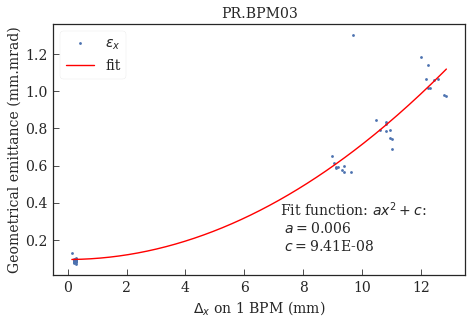

In [283]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('single_BPM185.eps', format='eps')

## 2) All BPM - single turn method

In [139]:
exp_a_allBPM = np.mean((1 + (BPM_alphax**2))/(2*BPM_betax))

Model function: a(x)^2 + c
Fit params: 
 a= 0.0174712306312+/-0.000806788254562
 c= 6.9831436279e-07+/-7.9604912823e-09
 
Expected value for the fit a=0.0282644589046


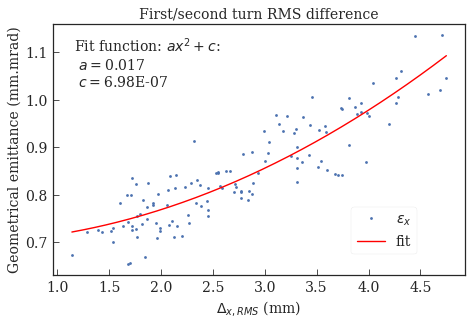

In [140]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: \n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.95, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True, bbox_to_anchor=(0.9,0.3))
print ' '
print 'Expected value for the fit a='+str(exp_a_allBPM)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

# Laslett tune shift calculation

In [81]:
myDataFrame['peakLineDensity'] = 0.6

In [82]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [83]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

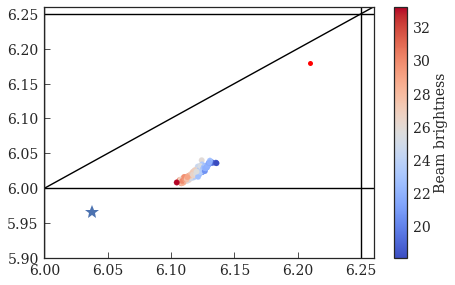

In [98]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.21
Qy = 6.18
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.0, 6.26])
plt.ylim([5.9, 6.26])
# tune shifts
p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.6, 0.5e-3,
              1e-6*0.943, 1e-6*0.775,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [95]:
myDataFrame['WS_emittance_y'].min()

0.80106210163967961